# Step 4 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Chris Larkin (c.larkin@ncl.ac.uk)
Created: 2023-10-4  
Last modified: 2025-05-13

TODO

- ltns un-prioritised growth to compare against ltn prioritsed 
- clean triangulation for concave shapes
- methods plotting for removing slivers etc
- cycle network investment within LTNs, converting pedestrain streets so that you can cycle through. Could have a big impact on the lcc size
- can't take multiple places as an input (my bad coding skills...), need to be able to take several places at a time
- save outputs as geopackages

## Preliminaries

### Parameters

In [1]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py

%load_ext watermark
#%watermark -n -v -m -g -iv
PATH['exports_gpkg'] = '../../bikenwgrowth_external/exports_gpkg/'

Loaded PATH.

Setup finished.



### Functions

In [3]:
%run -i functions.py

Loaded functions.



### Network weighting tags

In [4]:
%run -i tag_lts.py
%run -i distance_cost.py

# Routing 

## Setup for growth

The function and code below currently routes between the edges of neighbourhoods, rather than from a single point to a single point. We then join the neighbourhoods up first, before considering the wider area. This wider area is derived from hexagonal tesslleations within the city boundaries.

In [5]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



### Load data

G_caralls - no addtional weighting

G_weighted - for routing. lts applied + zero bike infrastucutre cost

G_investment distance - for finding distances between points in abstract (greedy_gdf) graph. cycle infrastucre has no cost, everything else has default distance

greedy_gdf[distance] - the investment length (routed length - any infrastucture)

GT "length" - actual distance between points

In [6]:
# get graphs

locations = {}
parameterinfo = osmnxparameters['carall']
G_caralls = {}
G_caralls_simplified = {}


# reload graph to ensure we have highway type information
G_caralls[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

# set up a graph for weighting by LTS, one without any weighting and one for finding the "true" distance of investment per path
G_weighted = copy.deepcopy(G_caralls[placeid])
G_investment_distance = copy.deepcopy(G_caralls[placeid])
G_default = copy.deepcopy(G_caralls[placeid])


# weight graphs
for u, v, key, data in G_weighted.edges(keys=True, data=True):
    highway = data.get('highway') 
    length = data.get('length')  
    lts = tag_lts.get(highway, 1)  # Get the LTS value, default to 1 if highway type not in tag_lts
    G_weighted[u][v][key]['length'] *= lts  # Multiply length by LTS value

for u, v, key, data in G_investment_distance.edges(keys=True, data=True):
    highway = data.get('highway') 
    length = data.get('length')  
    distance = distance_cost.get(highway, 1)  
    G_investment_distance[u][v][key]['length'] *= distance





# set the graph to route on to undirected 
G_weighted = G_weighted.to_undirected()
G_investment_distance = G_investment_distance.to_undirected()
G_default = G_default.to_undirected()

# get biketrack graph
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
G_biketrack = ox_gpkg_to_graph(gpkg_path)
G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))


# get biketrack graph without LTNs
gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack_no_ltn.gpkg'
G_biketrack_no_ltn = ox_gpkg_to_graph(gpkg_path)
G_biketrack_no_ltn.remove_nodes_from(list(nx.isolates(G_biketrack)))

In [7]:
# get nodes 


for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"Processing {placeid}")
    
    # Load Tesselation POIs (hard coded for now)
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + 'tessellation' + '_nnidsbikeall.csv') as f:
        tessellation_nnids = [int(line.rstrip()) for line in f]


    # Load LTN POIs
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        if location.geometry[0].geom_type == 'MultiPolygon':
            location = location.explode(index_parts=False).reset_index(drop=True)
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        try:
            location = Polygon(shapely.geometry.shape(first['geometry']))  # If shape file is given as linestring
        except:
            location = shapely.geometry.shape(first['geometry'])
    locations[placeid] = location
    
    G_caralls[placeid] = csv_to_ox_highway(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_caralls[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
    G_caralls_simplified[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
    G_caralls_simplified[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py

    print(f"{placeid}: Loading and moving POIs")
    # Get the carall graph and location geometry
    location = locations[placeid]
    G_carall = G_caralls_simplified[placeid]

    # Load neighbourhoods and create GeoDataFrame for centroids
    neighbourhoods = load_neighbourhoods(PATH["data"] + placeid + "/")
    all_centroids = gpd.GeoDataFrame(columns=['neighbourhood_id', 'geometry'], crs='EPSG:4326')  
    

    # load tesselation points 
    tess_nodes = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_poi_tessellation.gpkg')

    exit_points = get_exit_nodes(neighbourhoods, G_biketrack)
    if export:
        file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_exit_points.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
        exit_points.to_file(file_path, driver="GPKG")

    
        
    unique_id = 0  # Counter for unique IDs across neighbourhoods

    for name, gdf in neighbourhoods.items():  # Process each neighbourhood GeoDataFrame to get centroids, exit points, and neighbourhood IDs
        if gdf.empty:
            print(f"Warning: The GeoDataFrame for {name} is empty. Skipping...")
            continue
        print(f"Processing neighbourhoods in: {name}")

        # Assign a unique ID to each neighbourhood in the GeoDataFrame to reference throughout
        gdf['neighbourhood_id'] = range(unique_id, unique_id + len(gdf))
        if debug:
            print(f"Assigned neighbourhood_ids from {unique_id} to {unique_id + len(gdf) - 1} for {name}")

        # Get centroids to inherit 'neighbourhood_id'
        centroids_gdf = get_neighbourhood_centroids(gdf)
        all_centroids = pd.concat([all_centroids, centroids_gdf], ignore_index=True)
        unique_id += len(gdf)  # Increment by the number of neighbourhoods processed

    # Snap centroids to the closest nodes in the street network
    neighbourhood_nnids = set()
    for g in all_centroids['geometry']:
        n = ox.distance.nearest_nodes(G_carall, g.x, g.y)
        if n not in neighbourhood_nnids and haversine((g.y, g.x), (G_carall.nodes[n]["y"], G_carall.nodes[n]["x"]), unit="m") <= snapthreshold:
            neighbourhood_nnids.add(n)
    # Add nearest_node column to all_centroids by finding the nearest node for each centroid geometry
    all_centroids['nearest_node'] = all_centroids['geometry'].apply(
        lambda g: ox.distance.nearest_nodes(G_carall, g.x, g.y))  # We now have all_centroids with 'neighbourhood_id', 'geometry', 'nearest_node' columns
    
    ltn_nodes = all_centroids

    # add nearest node ID from G_carall 
    tess_nn = get_nearest_nodes_to_gdf(G_carall, tess_nodes)
    ltn_nn = get_nearest_nodes_to_gdf(G_carall, ltn_nodes)
    tess_nodes['osmid'] = tess_nn
    ltn_nodes['osmid'] = ltn_nn

    # combine nodes 
    combined_nodes = pd.concat([tess_nodes, ltn_nodes], ignore_index=True)

    # save them
    tess_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_tess_points.gpkg", driver="GPKG")
    ltn_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_ltn_points.gpkg", driver="GPKG")
    combined_nodes.to_file(PATH["data"] + placeid + "/" + placeid + "_combined_points.gpkg", driver="GPKG")


Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Processing newcastle
newcastle: Loading and moving POIs
1 Cities loaded


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:2106: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = gdf.explode().reset_index(drop=True)
c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing neighbourhoods in: newcastle


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:1774: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # Calculate centroids for each polygon


## EBC Growth - Set connection order

Build LTN triangulation

In [8]:
# Produce triangulation for LTN nodes
# only needed to set up full trianuglation, not needed later.
# ltn nodes are not ordered (nor do they need to be at this stage)
greedy_triangulation_ltns_gdf = greedy_triangulation_ltns(ltn_nodes)
ltn_node_pairs = get_ltn_node_pairs(ltn_nodes, greedy_triangulation_ltns_gdf) 
if export:
    file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_greedy_triangulation_ltns.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
    greedy_triangulation_ltns_gdf.to_file(file_path, driver="GPKG")


Build full triangulation using greedy triangulation

In [9]:
# Build the greedy triangulation graph using both sets of seed points
greedy_gdf, ltn_gdf, tess_gdf = build_greedy_triangulation(ltn_nodes, tess_nodes)
max_length = greedy_gdf['distance'].sum() # find the size of the fully connected graph

Clean up greedy triangulation to remove silver triangles, and unrealisticly long links.
- Removing silvers removes links which would pass along the same route (thus essentially duplicating themselves)
- Links longer than 5km are not realistic links to be making, they almost always link rural to rural over routes which can be made

In [ ]:
# find very long links
greedy_gdf = greedy_gdf[greedy_gdf["distance"] <= 5000]

# find slivers and remove the longest edge from them
fas = momepy.FaceArtifacts(greedy_gdf) 
# run FaceArtifacts (cf https://docs.momepy.org/en/stable/api/momepy.FaceArtifacts.html)
fas.polygons = fas.polygons.set_crs(greedy_gdf.crs)
threshold = 10
polys = fas.polygons.copy()
slivers = polys[polys['face_artifact_index'] < threshold]
slivers["centroid"] = slivers.geometry.centroid
centroids = slivers["centroid"]
bounding = find_bounding_lines(centroids, greedy_gdf)
longest_lines = []
for pt_idx, line_idxs in bounding.items():
    if not line_idxs:
        longest_lines.append(None)  
        continue
    lines = test.loc[line_idxs]
    # Find the longest line
    max_line = lines.loc[lines["distance"].idxmax()]
    longest_lines.append(max_line.name)
lines_to_drop = [idx for idx in longest_lines if idx is not None]
greedy_gdf = greedy_gdf.drop(index=lines_to_drop)

c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
if methods_plotting:
    greedy_gdf

### Build Full Triangulation (cont.)

In [91]:
# get node pairs of ltn-to-tess, tess-to-ltn, and tess-to-tess
combined_node_pairs = get_node_pairs(combined_nodes, greedy_gdf)
combined_node_pairs = [pair for pair in combined_node_pairs if pair not in ltn_node_pairs]

Apply Level of Traffic Stress to triangulation distances

In [191]:
# find the routed distance (using level of traffic stress as a weighting) between each link, prior to calcualting the betweenness centrialty
greedy_gdf['sp_lts_route'] = greedy_gdf.apply(lambda row: nx.shortest_path(G_weighted, source=row['start_osmid'], target=row['end_osmid'], weight='length'), axis=1)
greedy_gdf['sp_lts_distance'] = greedy_gdf['sp_lts_route'].apply(lambda route: sum(G_weighted[u][v][0]['length'] for u, v in zip(route[:-1], route[1:])))
# find normal network distance for directness analysis

#G_default = copy.deepcopy(G_weighted) ## remove, G_weighted has lengths as zero so cannot be deweighted
#deweight_edges(G_default, tag_lts)

greedy_gdf['sp_true_distance'] = greedy_gdf['sp_lts_route'].apply(lambda route: sum(G_default[u][v][0]['length'] for u, v in zip(route[:-1], route[1:])))
greedy_gdf['eucl_dist'] = greedy_gdf['distance'] # save for directness analysis

In [192]:
# Create the graph from the triangulation GeoDataFrame
greedy_nx = nx.Graph()
for _, row in greedy_gdf.iterrows():
    start = row['start_osmid']
    end = row['end_osmid']
    sp_lts_distance = row['sp_lts_distance']
    greedy_nx.add_edge(start, end, geometry=row['geometry'], sp_lts_distance=sp_lts_distance)

Get shortest paths

In [193]:
shortest_paths_ltn = []
shortest_paths_other = []
for node1, node2 in ltn_node_pairs:
    try:
        path = nx.shortest_path(greedy_nx, source=node1, target=node2, weight='sp_lts_distance')
        shortest_paths_ltn.append(path)
    except nx.NetworkXNoPath:
        print(f"No path between {node1} and {node2}")
for node1, node2 in combined_node_pairs:
    try:
        path = nx.shortest_path(greedy_nx, source=node1, target=node2, weight='sp_lts_distance')
        shortest_paths_other.append(path)
    except nx.NetworkXNoPath:
        print(f"No path between {node1} and {node2}")


Find path values for ranking: Get order using sum of { (ebc of edge * (length of edge/sum of length of edges) ) } / number-of-edges.

Distance used in these functions is the routed lts distance in meters

In [194]:
# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(greedy_nx, weight='sp_lts_distance')

# find path values
ebc_ltn = get_sp_ebc_weights(ltn_node_pairs, shortest_paths_ltn, greedy_nx, edge_betweenness)
ebc_other = get_sp_ebc_weights(combined_node_pairs, shortest_paths_other, greedy_nx, edge_betweenness)

# order by betweenness path value
ebc_ltn = dict(sorted(ebc_ltn.items(), key=lambda item: item[1], reverse=True))
ebc_other = dict(sorted(ebc_other.items(), key=lambda item: item[1], reverse=True))

# set up shortest paths for looping through in budget adjustment
shortest_paths_ltn = {
    (path[0], path[-1]): [(path[i], path[i+1]) for i in range(len(path)-1)]
    for path in shortest_paths_ltn
}
shortest_paths_other =  {
    (path[0], path[-1]): [(path[i], path[i+1]) for i in range(len(path)-1)]
    for path in shortest_paths_other
}


### Compute routed edge lengths for abstract graph

This ensures we use our "budget" correctly. We first find the optimal route using the LTS tags per connection, then "deweight" the path to find the "true" length of the connection in meters. Existing infrastucture (bike paths etc) are not included in the "true" length, as we do not need to build these facilities.

In [195]:
## find the routed distance between edges in abstract GT
centroid_osmids = set(all_centroids['osmid'])
greedy_gdf['ltn_origin'] = greedy_gdf['start_osmid'].isin(centroid_osmids)
greedy_gdf['ltn_destination'] = greedy_gdf['end_osmid'].isin(centroid_osmids)

# Build a mapping from centroid osmid to neighbourhood_id
osmid_to_neigh = dict(zip(all_centroids['osmid'], all_centroids['neighbourhood_id']))

# Build a mapping from neighbourhood_id to list of exit point osmids
neigh_to_exits = defaultdict(list)
for idx, row in exit_points.iterrows():
    neigh_to_exits[row['neighbourhood_id']].append(row['osmid'])

# Compute the shortest path and store in 'sp_route'
greedy_gdf['sp_route'] = greedy_gdf.apply(lambda row: compute_routed_path_for_GT(row, G_weighted), axis=1)

# Find lengths of shortest paths on G_investment_distance
## this is the true distance of the investment, without LTS weighting but also without distances for existing infrastructure
greedy_gdf['distance'] = greedy_gdf['sp_route'].apply(
    lambda route: calculate_sp_route_distance(route, G_investment_distance)
)

del greedy_gdf['sp_route']

Now "Distance" is the length of investment required to connect two locations via the best(shortest with weighting of LTS) path

In [196]:
if methods_plotting:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    location = locations[placeid]
    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
    location_gdf.plot(ax=ax, color='lightgrey', zorder=0) 

    # add seed points
    tess_nodes.plot(ax=ax, color='red', markersize=10, zorder=2)
    ltn_nodes.plot(ax=ax, color='red', markersize=10, zorder=3)
    #greedy_gdf.to_crs(location_gdf.crs).plot(ax=ax, color='blue', linewidth=0.9, zorder=1)

    # add ebc
    ebc_df = pd.DataFrame([{'start': min(u, v), 'end': max(u, v), 'betw': w} for (u, v), w in edge_betweenness.items()])
    merged_gdf = (greedy_gdf.assign(start_norm=greedy_gdf[['start_osmid', 'end_osmid']].min(axis=1),
                                    end_norm=greedy_gdf[['start_osmid', 'end_osmid']].max(axis=1))
                                    .merge(ebc_df, left_on=['start_norm', 'end_norm'], right_on=['start', 'end'], how='left')).to_crs(location_gdf.crs)
    merged_gdf.plot(ax=ax, column='betw', legend=True, cmap='viridis', linewidth=2, zorder=1, legend_kwds={'shrink': 0.6, 'label': "Normalised Edge Betweenness Centrality"})
    plt.axis('off')
    plt.savefig(PATH["plots"] + placeid + "/greedy_tri_ebc_map.png", dpi=600,  bbox_inches='tight')
    

    ############ PLOT DOUBLE GREEDY #############
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    location = locations[placeid]
    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
    location_gdf.plot(ax=ax, color='lightgrey', zorder=0) 

    # add seed points
   # tess_nodes.plot(ax=ax, color='red', markersize=10, zorder=4)
    ltn_nodes.plot(ax=ax, color='darkorange', markersize=50, zorder=3)
    #greedy_gdf.to_crs(location_gdf.crs).plot(ax=ax, olor='blue', linewidth=0.9, zorder=1)
    greedy_gdf.to_crs(location_gdf.crs).plot(ax=ax, color='firebrick', linewidth=1, zorder=1)
    greedy_triangulation_ltns_gdf.to_crs(location_gdf.crs).plot(ax=ax, color='royalblue', linewidth=2, zorder=2)
    plt.axis('off')
    plt.savefig(PATH["plots"] + placeid + "/greedy_tri_neighbours_map.png", dpi=600,  bbox_inches='tight')

    
    plt.show()



In [197]:
if export:
    # add ebc
    ebc_df = pd.DataFrame([{'start': min(u, v), 'end': max(u, v), 'betw': w} for (u, v), w in edge_betweenness.items()])
    merged_gdf = (greedy_gdf.assign(start_norm=greedy_gdf[['start_osmid', 'end_osmid']].min(axis=1),
                                    end_norm=greedy_gdf[['start_osmid', 'end_osmid']].max(axis=1))
                                    .merge(ebc_df, left_on=['start_norm', 'end_norm'], right_on=['start', 'end'], how='left')).to_crs(4326)
    file_path = os.path.join(PATH["exports_gpkg"] + placeid + "/" + f"{placeid}_greedy_triangulation.gpkg"); os.makedirs(os.path.dirname(file_path), exist_ok=True)
    merged_gdf.to_file(file_path, driver="GPKG")

### Do the routing

Find the size of a fully connected network

In [198]:
## find the size of the fully connected network
total_distance = greedy_gdf['distance'].sum() 

if debug:
    print("Total distance of fully connected network: ", total_distance)

In [199]:
# set investment max to a fully connected bicycle network, and interval to 1% incremental steps
points = np.linspace(0, total_distance, 101)
# Drop 0 as we don't need to consider the empty network
investment_levels = points[1:].tolist()

Greedy triangulation "distance" is the length of the shortest path distance between edges once routed on to the network, without including any length from existing infrastucture. 

Create iterations of network growth:

In [154]:
## betwenness
## many combinations
previous_selected_edges = set()

GT_abstracts = []
GT_abstracts_gdf = []
GTs = []
GTs_gdf = []



global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
    if debug:
        print(f"Remaining edges to add: {remaining_edges}")
    
    GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    # poipairs = connected_ltn_pairs | connected_other_pairs
    poipairs = list(GT_abstract_nx.edges())
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    GTs.append(GT)
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GTs_gdf.append(GT_edges)


    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    GTs_igraph = [ig.Graph.from_networkx(gt) for gt in GTs]
    GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs_igraph, "GT_abstracts": GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

        





Pruning GT abstract and routing on network for meters of investment:   0%|          | 0/100 [00:00<?, ?it/s]

## Random growth - Set connection order (to make a baseline comparision)

In [155]:
# ## grow randomly

# random_edges = pd.Series(False, index=greedy_gdf.index)  
# distance = 0.0 # needed for budget
# Random_GT_Abstracts = []  

# for level in investment_levels:
#     # Calculate remaining budget for new edges
#     remaining_budget = level - distance
    
#     if remaining_budget > 0:
#         unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
#         if not unselected_edges.empty:
#             shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
#             cumulative_distances = shuffled_edges['distance'].cumsum()
#             within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
#             new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
#             random_edges[new_indices] = True
#             if within_budget.any():
#                 distance += cumulative_distances[within_budget].iloc[-1]
#     # save edges
#     current_gdf = greedy_gdf[random_edges].copy()

#     GT_abstract_nx = gdf_to_nx_graph(current_gdf)
#     Random_GT_Abstracts.append(current_gdf)
#     print(len(Random_GT_Abstracts))
#     print(f"Iteration with investment level {level}: {len(new_indices)} new edges added")

   
#     node_pairs = list(GT_abstract_nx.edges())
#     print(f"Node pairs in GT_abstract_nx: {node_pairs}")




In [156]:
## many combinations
random_edges = pd.Series(False, index=greedy_gdf.index)  
distance = 0.0 # needed for budget

Random_GT_abstracts = []
Random_GTs = []
Random_GTs_gdf = []
Random_GT_abstracts_gdf = []

# reset global variables
global_processed_pairs_random = set()
cumulative_GT_indices_random = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract randomly and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    # Calculate remaining budget for new edges
    remaining_budget = D - distance
    
    if remaining_budget > 0:
        unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
        if not unselected_edges.empty:
            shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
            cumulative_distances = shuffled_edges['distance'].cumsum()
            within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
            new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
            random_edges[new_indices] = True
            if within_budget.any():
                distance += cumulative_distances[within_budget].iloc[-1]
    # save edges
    GT_abstract_gdf = greedy_gdf[random_edges].copy()
    Random_GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    Random_GT_abstracts.append(GT_abstract_nx)
    poipairs = list(GT_abstract_nx.edges()) # store currently connected points for routing

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    
    routenodepairs = [(u, v) for u, v in poipairs]
   

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs_random or tuple(reversed(poipair)) in global_processed_pairs_random:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"with a path length of", shortest_path_length , "on path: ", best_path)
                    print("The exit points were:", exit_points_a)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices_random.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices_random)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            


    Random_GTs.append(GT)
    Random_GT_nodes, Random_GT_edges = ox.graph_to_gdfs(GT) # what if GT is empty on the first random selection?
    Random_GTs_gdf.append(Random_GT_edges)
        
    

    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    Random_GTs_igraph = [ig.Graph.from_networkx(gt) for gt in Random_GTs]
    Random_GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in Random_GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": random, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs_igraph, "GT_abstracts": Random_GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, random, ".pickle", weighting=weighting)

        





Pruning GT abstract randomly and routing on network for meters of investment:   0%|          | 0/100 [00:00<?,…

## Saving files


Files are saved to a pickle. They will be of the form "newcastle_poi_LTNs_tessellation_betweenness_weighted.pickle". 

Saving as pickles

In [157]:
prune_measure = "betweenness"

results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs, "GT_abstracts": GT_abstracts}
write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [158]:
prune_measure = "random"

results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs, "GT_abstracts": Random_GT_abstracts}
write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

Save as geodataframes

In [159]:
## to do

## Loading Saved files

Lists of graphs are loaded back in after being stored as pickles

In [160]:
# betweeness
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_{prune_measure}_weighted.pickle"  

with open(filename, "rb") as f:
    results = pickle.load(f)


# random
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_random_weighted.pickle"  

with open(filename, "rb") as f:
    results_random = pickle.load(f)

In [161]:
# # how to access....
# investment_levels = results["prune_quantiles"]
# GTs = results["GTs"]
# GT_abstracts = results["GT_abstracts"]

# # For example, convert the first graph in GTs to GeoDataFrames
# import osmnx as ox
# nodes, edges = ox.graph_to_gdfs(GTs[0])


## Potential Demand Growth

#### Loading PCT results - Predownloaded

In [ ]:
# read in lines
lines = gpd.read_file(PATH["example-data"] +  "/lines_lsoa.gpkg")
rnet = gpd.read_file(PATH["example-data"] + "/rnet_lsoa.gpkg")
lsoa = gpd.read_file(PATH["example-data"] + "/lsoa.gpkg")
lsoa_bound = gpd.read_file(PATH["example-data"] + "/lsoa_bound.gpkg")

# clip to boundary
boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])
#lines = gpd.clip(lines, boundary) # dont clip, otherwise lines which pass temporarily outside the boundary will be removed
rnet = gpd.clip(rnet, boundary)
lsoa = gpd.clip(lsoa, boundary)
lsoa_bound = gpd.clip(lsoa_bound, boundary)
valid_lad11cds = lsoa['lad11cd'].unique()
lines = lines[lines['lad11cd1'].isin(valid_lad11cds) & lines['lad11cd2'].isin(valid_lad11cds)] # do this instead


# test = G_pct_gdfs[99]
# test.plot()
# total_length_m = test['length_m'].sum()
# total_length_m


# test1 = GTs_gdf[99]
# test1.plot()
# total_length_m = test1['length'].sum()
# total_length_m


# m = test.explore()
# test1.explore(m=m, color='red')

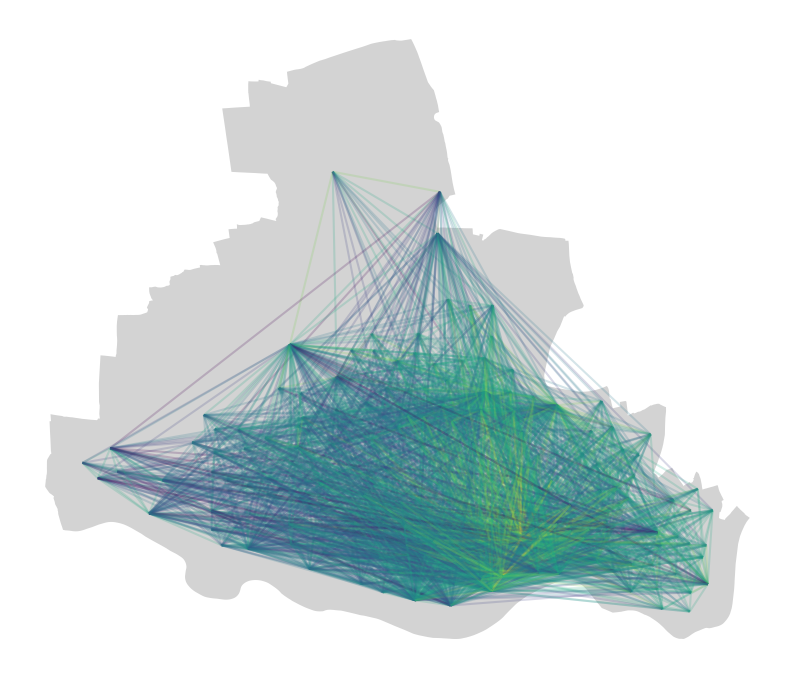

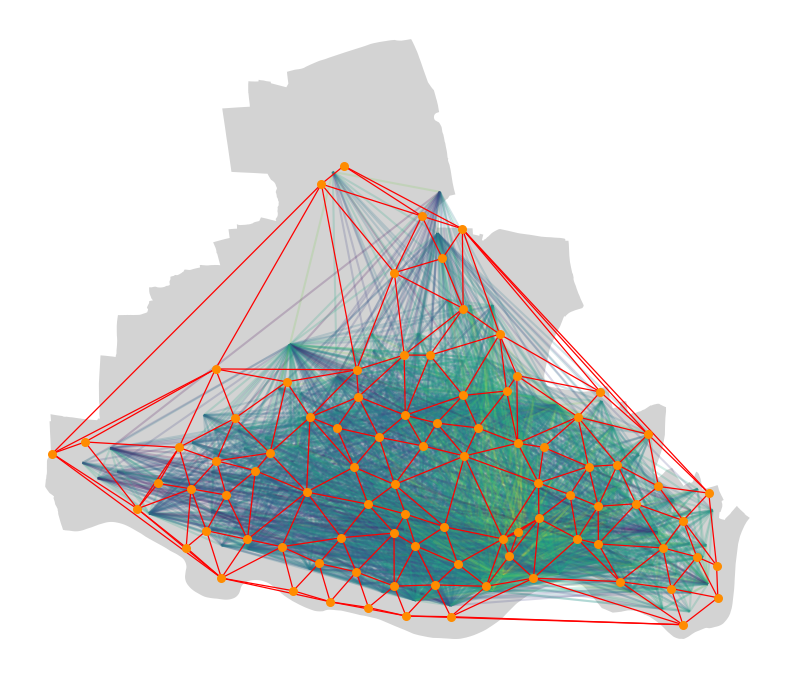

In [219]:
if methods_plotting:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    location = locations[placeid]
    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
    location_gdf.plot(ax=ax, color='lightgrey', zorder=0)

    # add pct lines
    lines.plot(ax=ax, column = "dutch_slc", scheme='Percentiles', alpha=0.2)

    plt.axis('off')
    plt.savefig(PATH["plots"] + placeid + "/pct_raw_demand.png", dpi=600,  bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    location = locations[placeid]
    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
    location_gdf.plot(ax=ax, color='lightgrey', zorder=0)

    # add pct lines
    lines.plot(ax=ax, column = "dutch_slc", scheme='Percentiles', alpha=0.2)
    ltn_nodes.plot(ax=ax, color='darkorange', markersize=30, zorder=5)
    tess_nodes.plot(ax=ax, color='darkorange', markersize=30, zorder=4)
    greedy_gdf.to_crs(lines.crs).plot(ax=ax, color='red', linewidth=0.9, zorder=3)

    plt.axis('off')
    plt.savefig(PATH["plots"] + placeid + "/pct_greddy_setup.png", dpi=600,  bbox_inches='tight')
    plt.show()

### PCT Demand to GT

In order to get better demand data, we can transform the desire lines from the PCT's potential demand into the ordering method of links in our greedy triangulation. This can be compared against using betweeness centraility, which up until now has been used as our proxy for demand.

PCT desire lines go from LSOA centriods, which are at a different scale to our start and end points. To deal with this, we link each lsoa to its nearest seed point. We can then aggregate the demand between seed points. 

#### Join 

In [211]:
join = gpd.sjoin_nearest(lsoa[['geometry']], combined_nodes[['osmid', 'geometry']], how='left')
lsoa['nearest_seed_point'] = join['osmid']

c:\Users\b8008458\AppData\Local\miniforge3\envs\growbikenet\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


### Aggregate demand

This method looks to simply spatial join. The issue with this is that some node are not served. Skip this section and run the k-NN approach

In [165]:
# # Create a dictionary mapping geo_code to nearest_seed_point (osmid)
# geocode_to_osmid = lsoa.set_index('geo_code')['nearest_seed_point'].to_dict()

# # Map geo_code1 and geo_code2 to their corresponding osmids
# lines['osmid_start'] = lines['geo_code1'].map(geocode_to_osmid)
# lines['osmid_end'] = lines['geo_code2'].map(geocode_to_osmid)

# # drop lines which start or finish external to the area
# lines = lines.dropna(subset=['osmid_start', 'osmid_end']).query("osmid_start != osmid_end")


# # group by osmid pairs
# lines['osmid_pairs'] = lines.apply(lambda row: tuple(sorted((row['osmid_start'], row['osmid_end']))), axis=1)

# if debug: 
#     for col in lines.columns:
#         print(col)

        
# # clean
# lines = lines[['osmid_start', 'osmid_end', 'geometry', 'length_m', 'osmid_pairs', 'dutch_slc']]


In [166]:
# lines['osmid_start'] = lines['osmid_start'].astype('int64')
# lines['osmid_end'] = lines['osmid_end'].astype('int64')
# lines['osmid_pairs'] = list(zip(lines['osmid_start'], lines['osmid_end']))


# total_dutch_slc = lines.groupby('osmid_pairs')['dutch_slc'].sum().reset_index(name='total_dutch_slc')

# # join demand to greedy triangulation
# greedy_gdf['osmid_pairs'] = list(zip(greedy_gdf['start_osmid'], greedy_gdf['end_osmid']))
# greedy_gdf['start_osmid'] = greedy_gdf['start_osmid'].astype('int64')
# greedy_gdf['end_osmid'] = greedy_gdf['end_osmid'].astype('int64')
# greedy_gdf = greedy_gdf.merge(total_dutch_slc, on ='osmid_pairs', how='left')

# #greedy_gdf['total_dutch_slc'] = greedy_gdf['total_dutch_slc'].fillna(0) 


In [167]:
# # Make a copy of combined_nodes and reproject to Web Mercator (EPSG:3857)
# combined_nodes_web_mercator = combined_nodes.to_crs(epsg=3857)

# # Buffer the geometries by 200 meters
# combined_nodes_web_mercator['geometry'] = combined_nodes_web_mercator['geometry'].buffer(1000)

# lsoa_web_mercator = lsoa.to_crs(epsg=3857)
# lsoa_web_mercator['geometry'] = lsoa_web_mercator['geometry'].buffer(500)

In [168]:
# m= lsoa.explore()
# lsoa_bound.explore(m=m)
# greedy_gdf.explore(m=m, color='green', opacity=0.5)
# combined_nodes.explore(m=m, color='red')
# #lines.explore(m=m, opacity=0.1)



In [169]:
# # Filter the rows where total_dutch_slc is not equal to zero
# filtered_greedy_gdf = greedy_gdf[greedy_gdf['total_dutch_slc'].notna() & (greedy_gdf['total_dutch_slc'] != 0)]

In [170]:
# # Plot the lines with colors based on their groups
# fig, ax = plt.subplots(figsize=(10, 10))
# for group, color in group_color_map.items():
#     group_lines = lines[lines['group'] == group]
#     group_lines.plot(ax=ax, color=color, label=str(group))


# # Plot combined_nodes in blue
# combined_nodes.plot(ax=ax, color='blue', markersize=5, label='Combined Nodes')

# # Plot lsoa in red
# lsoa.plot(ax=ax, color='red', markersize=5, label='LSOA', zorder=1)

# # Add legend and show plot
# plt.legend(title='Groups (osmid_start, osmid_end)', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()



### k-nearest neighbours

find nearest neighbours of seed points, then weight demand by inverse distance from 

This joins demand to lines via a k-Nearest Neighbour approach.

In [212]:

# reproject
lsoa = lsoa.to_crs(epsg=3857)
lines = lines.to_crs(epsg=3857)
combined_nodes = combined_nodes.to_crs(epsg=3857)   
greedy_gdf = greedy_gdf.to_crs(epsg=3857)



# Convert geo_code columns to strings for consistency
lsoa['geo_code'] = lsoa['geo_code'].astype(str)
lines['geo_code1'] = lines['geo_code1'].astype(str)
lines['geo_code2'] = lines['geo_code2'].astype(str)

# Compute coordinates
lsoa['x'] = lsoa.geometry.x
lsoa['y'] = lsoa.geometry.y
combined_nodes['x'] = combined_nodes.geometry.x
combined_nodes['y'] = combined_nodes.geometry.y

# k-NN setup
k = 3 # CHANGE
combined_coords = combined_nodes[['x', 'y']].values
lsoa_coords = lsoa[['x', 'y']].values

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(combined_coords)
distances, indices = nbrs.kneighbors(lsoa_coords)

# Build mapping dictionary (geo_code -> list of (osmid, normalized_weight))
mapping = {}
for i, row in enumerate(lsoa.itertuples()):
    lsoa_code = row.geo_code
    node_indices = indices[i]
    dists = distances[i]
    # Avoid division by zero by adding a small constant
    weights = 1 / (dists + 1e-6)
    normalised_weights = weights / weights.sum()
    node_ids = combined_nodes.iloc[node_indices]['osmid'].values
    mapping[lsoa_code] = list(zip(node_ids, normalised_weights))

# Debug: check mapping keys
if debug: 
    print("Mapping keys (first 10):", list(mapping.keys())[:10])
    print("Total LSOA mapping entries:", len(mapping))

# Generate flow records from desire lines
flow_records = []
for idx, row in lines.iterrows():
    origin_code = row['geo_code1']
    dest_code = row['geo_code2']
    demand = row['dutch_slc']

    # Debug: report missing mappings if any
    if debug:
        if origin_code not in mapping:
            print(f"Origin code {origin_code} not in mapping")
        if dest_code not in mapping:
            print(f"Destination code {dest_code} not in mapping")

    if origin_code in mapping and dest_code in mapping:
        origin_nodes = mapping[origin_code]
        dest_nodes = mapping[dest_code]
        total_weight_product = sum(w_o * w_d for (_, w_o) in origin_nodes for (_, w_d) in dest_nodes)
        for o_node, w_o in origin_nodes:
            for d_node, w_d in dest_nodes:
                flow_share = demand * (w_o * w_d) / total_weight_product
                node_pair = tuple(sorted((o_node, d_node)))
                flow_records.append({'osmid_pair': node_pair, 'flow': flow_share})

if debug:
    print("Number of flow records:", len(flow_records))

# Aggregate flows
flow_df = pd.DataFrame(flow_records)
if flow_df.empty:
    print("No flow records were generated. Check your mapping and geo_code consistency.")
else:
    total_flow = flow_df.groupby('osmid_pair')['flow'].sum().reset_index(name='total_flow')
    if debug:
        print(total_flow.head())

    # Merge with network data (greedy_gdf)
    greedy_gdf = greedy_gdf.copy()
    
    # Ensure osmid_pair is built as sorted tuples to match total_flow keys
    greedy_gdf['osmid_pair'] = greedy_gdf.apply(
        lambda row: tuple(sorted((int(row['start_osmid']), int(row['end_osmid'])))), axis=1
    )
    
    # Merge the flows
    greedy_gdf = greedy_gdf.merge(total_flow, on='osmid_pair', how='left')
    greedy_gdf['total_flow'] = greedy_gdf['total_flow'].fillna(0)
    if debug: 
        print(greedy_gdf[['osmid_pair', 'total_flow']].head())


lsoa = lsoa.to_crs(epsg=4326)
lines = lines.to_crs(epsg=4326)
combined_nodes = combined_nodes.to_crs(epsg=4326)   
greedy_gdf = greedy_gdf.to_crs(epsg=4326)


In [213]:
greedy_gdf

,geometry,start_osmid,end_osmid,distance,sp_lts_route,sp_lts_distance,sp_true_distance,eucl_dist,ltn_origin,ltn_destination,osmid_pair,total_flow
0,"LINESTRING (-1.61558 54.97912, -1.61032 54.98041)",12091933082,4140896891,0.000,"[12091933082, 12091933081, 2326873605, 1113581...",3062.947,1118.711,366.611193,True,True,"(4140896891, 12091933082)",19.174459
1,"LINESTRING (-1.61332 54.97571, -1.61558 54.97912)",8254838993,12091933082,0.000,"[8254838993, 8254838992, 8254838988, 825483898...",2113.654,1036.753,406.684872,True,True,"(8254838993, 12091933082)",21.160177
2,"LINESTRING (-1.61430 55.00879, -1.61068 55.01189)",60150990,252100827,432.645,"[60150990, 1731802540, 8301427921, 1731802634,...",3151.173,1314.229,415.313673,True,True,"(60150990, 252100827)",34.544636
3,"LINESTRING (-1.58216 54.97811, -1.58948 54.97912)",776327170,345643357,171.304,"[776327170, 776327214, 776327226, 4634363980, ...",1352.248,676.124,481.877848,True,True,"(345643357, 776327170)",33.356059
4,"LINESTRING (-1.54082 54.97377, -1.54774 54.97552)",778308370,147056036,1293.488,"[778308370, 4618060202, 778308589, 778308274, ...",4050.863,1293.488,483.862687,False,False,"(147056036, 778308370)",12.243897
...,...,...,...,...,...,...,...,...,...,...,...,...
248,"LINESTRING (-1.63381 54.96351, -1.55257 54.96190)",6855654329,778308101,2593.105,"[6855654329, 6855654330, 6855654331, 685565433...",7319.361,13009.894,5207.010232,False,False,"(778308101, 6855654329)",0.000000
249,"LINESTRING (-1.56481 55.00010, -1.62975 55.04132)",705926870,1491749280,3692.728,"[705926870, 705926887, 705926890, 705926880, 3...",13030.638,8512.533,6189.885891,True,False,"(705926870, 1491749280)",0.914496
250,"LINESTRING (-1.64946 54.96365, -1.55257 54.96190)",824383078,778308101,2083.529,"[824383078, 824383194, 824383196, 824383197, 4...",5673.100,11751.393,6209.267416,False,False,"(778308101, 824383078)",0.098286
251,"LINESTRING (-1.54355 54.98830, -1.62975 55.04132)",300420365,1491749280,6986.140,"[300420365, 791959028, 791959021, 791959016, 7...",20645.538,11405.751,8077.899618,False,False,"(300420365, 1491749280)",0.098554


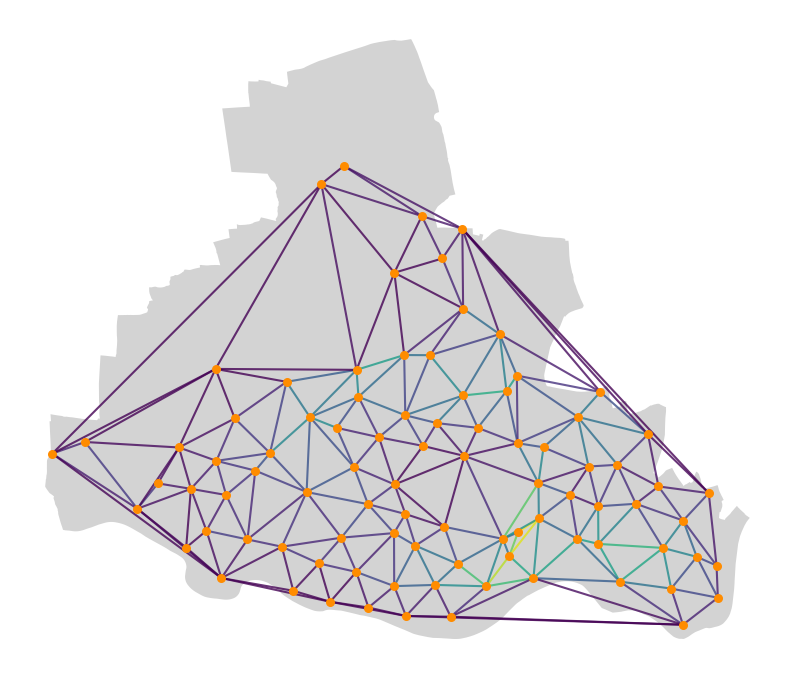

In [218]:
    
if methods_plotting:    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    location = locations[placeid]
    location_gseries = gpd.GeoSeries([location])
    location_gdf = gpd.GeoDataFrame(geometry=location_gseries)
    location_gdf = location_gdf.set_crs(epsg=4326, inplace=True)
    location_gdf.plot(ax=ax, color='lightgrey', zorder=0)


    ltn_nodes.plot(ax=ax, color='darkorange', markersize=30, zorder=5)
    tess_nodes.plot(ax=ax, color='darkorange', markersize=30, zorder=4)
    greedy_gdf.to_crs(lines.crs).plot(ax=ax, linewidth=1.5, zorder=3, column='total_flow', cmap='viridis', alpha=0.8)

    plt.axis('off')
    plt.savefig(PATH["plots"] + placeid + "/pct_greedy.png", dpi=600,  bbox_inches='tight')
    plt.show()

## Demand Growth - Set Connection


In [173]:
def get_sp_demand_weights(node_pairs, shortest_paths, graph, edge_length_key='sp_lts_distance'):
    """
    Calculate the demand from the PCT for each node pair's shortest path.
    For each edge in the path, weight its total_flow by the proportion of its length
    relative to the total length of the path and average across the number of edges.
    """
    result_dict = {}
    
    for node_pair in node_pairs:
        # Try to retrieve the path using the node pair as key (or its reverse if undirected)
        if node_pair in shortest_paths:
            path = shortest_paths[node_pair]
        elif tuple(reversed(node_pair)) in shortest_paths:
            path = shortest_paths[tuple(reversed(node_pair))]
        else:
            raise KeyError(f"Path for node pair {node_pair} not found in shortest_paths")
        
        # If the path is already a list of edges, use it directly.
        # Otherwise, assume it is a list of nodes and convert it to edge pairs.
        if path and isinstance(path[0], tuple) and len(path[0]) == 2:
            edges_in_path = path
        else:
            edges_in_path = [(path[j], path[j + 1]) for j in range(len(path) - 1)]
        
        edges_info = []
        for u, v in edges_in_path:
            edge_data = graph.get_edge_data(u, v)
            if edge_data is None:
                edge_data = graph.get_edge_data(v, u)
            if edge_data is None:
                raise ValueError(f"Edge ({u}, {v}) not found in graph for path {path}")
            
            length = edge_data.get(edge_length_key, 0)
            flow = edge_data.get('total_flow', 0)
            edges_info.append((length, flow))
        
        total_length = sum(length for length, _ in edges_info)
        num_edges = len(edges_info)
        
        if num_edges == 0:
            result_dict[node_pair] = 0.0
            continue
        
        weighted_sum = sum(flow * (length / total_length) for length, flow in edges_info) if total_length > 0 else 0.0
        result_dict[node_pair] = weighted_sum / num_edges
    
    return result_dict

greedy_nx = nx.Graph()
for _, row in greedy_gdf.iterrows():
    start = row['start_osmid']
    end = row['end_osmid']
    total_flow = row['total_flow']
    sp_lts_distance = row.get('sp_lts_distance', 0)  # Retrieve the distance value to ensure it's the average flow across sp rather than total
    greedy_nx.add_edge(
        start, end,
        geometry=row['geometry'],
        total_flow=total_flow,
        sp_lts_distance=sp_lts_distance
    )


demand_ltn = get_sp_demand_weights(ltn_node_pairs, shortest_paths_ltn, greedy_nx)
demand_other = get_sp_demand_weights(combined_node_pairs, shortest_paths_other, greedy_nx)


# order by betweenness path value
demand_ltn = dict(sorted(demand_ltn.items(), key=lambda item: item[1], reverse=True))
demand_other = dict(sorted(demand_other.items(), key=lambda item: item[1], reverse=True))

greedy_gdf = greedy_gdf.to_crs(3857)

In [174]:
## demand
## many combinations
previous_selected_edges = set()

GT_abstracts = []
GT_abstracts_gdf = []
GTs = []
GTs_gdf = []



global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, demand_ltn, shortest_paths_other, demand_other, previous_selected_edges, ltn_node_pairs)
    remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
    if debug:
        print(f"Remaining edges to add: {remaining_edges}")
    
    GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    # poipairs = connected_ltn_pairs | connected_other_pairs
    poipairs = list(GT_abstract_nx.edges())
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    GTs.append(GT)
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GTs_gdf.append(GT_edges)


    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    GTs_igraph = [ig.Graph.from_networkx(gt) for gt in GTs]
    GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in GT_abstracts]






Pruning GT abstract and routing on network for meters of investment:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Save
prune_measure = "demand"

results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs, "GT_abstracts": GT_abstracts}
write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

In [ ]:
breakpoint() # stop here for now

In [ ]:
Audio(sound_file, autoplay=True)

## Testing

#### Expermient with determining k in pct aggregation

The number of neighbours used in in the k-nn has an impact on how accurate assigning demand will be. Currently testing adaptive demand and using an elbow method

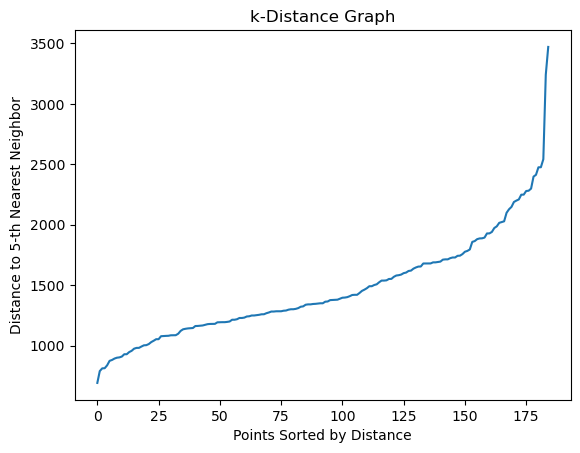

In [ ]:
from sklearn.neighbors import NearestNeighbors

k_test = 5  # Test with different values
nbrs = NearestNeighbors(n_neighbors=k_test).fit(lsoa[['x', 'y']])
distances, _ = nbrs.kneighbors(lsoa[['x', 'y']])

# Sort distances to the k-th neighbor
sorted_distances = np.sort(distances[:, k_test-1])

# Plot the sorted k-distances
plt.plot(sorted_distances)
plt.xlabel("Points Sorted by Distance")
plt.ylabel(f"Distance to {k_test}-th Nearest Neighbor")
plt.title("k-Distance Graph")
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Compute average distance to nearest 5 neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(lsoa[['x', 'y']])
distances, _ = nbrs.kneighbors(lsoa[['x', 'y']])
avg_dist = distances.mean(axis=1)

# Set adaptive k: more neighbors in sparse regions, fewer in dense regions
adaptive_k = np.round(1 + (avg_dist / avg_dist.max()) * 10).astype(int)

print("Adaptive k values (first 100):", adaptive_k[:100])


Adaptive k values (first 100): [9 5 6 5 6 6 5 6 5 5 5 6 4 5 5 7 5 5 6 5 5 5 4 5 4 4 4 5 5 4 5 4 5 4 4 4 5
 4 4 4 4 4 4 4 4 4 5 4 5 4 4 4 5 4 5 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 3 4 5
 4 4 5 5 6 5 5 5 4 5 5 4 3 4 4 3 4 3 4 3 3 4 4 4 4 4]


In [ ]:
greedy_gdf.explore(column='total_flow', cmap='viridis', legend=True, legend_name='Dutch SLC')

#### Produce a network using routed PCT dutch scenario

In [ ]:

# Sort the GeoDataFrame by 'dutch_slc' descending - most potential first
sorted_rnet = rnet.sort_values('dutch_slc', ascending=False)
cumulative_lengths = sorted_rnet['length_m'].cumsum().values

G_pct_gdfs = []

# Track the maximum index reached to avoid reprocessing
max_idx = 0

for D in investment_levels:
    # Find the furthest index where cumulative length <= D
    idx = np.searchsorted(cumulative_lengths[max_idx:], D, side='right') + max_idx
    idx = min(idx, len(sorted_rnet))  # Ensure we don't exceed the dataframe
    
    # Select edges up to this index
    subset = sorted_rnet.iloc[:idx]
    G_pct_gdfs.append(subset)
    
    # Update max_idx to reflect edges already included
    max_idx = idx



### General Testing

Attempt at getting population into buildings...

In [53]:
import ukcensusapi.Nomisweb as census_api

os.environ["NOMIS_API_KEY"] = "0x98f2ffbbe685f2623fa5c201d4ff86a8c9c46dee"

api = census_api.Nomisweb(cache_dir = PATH["data"]+ "/" + placeid)

# Define the dataset and geography
dataset_id = "NM_2010_1"  # Ensure this is the correct dataset ID
geography = "LSOA11"      # 2021 LSOA geography type
measures = ["OBS_VALUE"]  # Population measure

# List of LSOA codes you're interested in
lsoa_codes = lsoa_bound["geo_code"].tolist()  # Assuming lsoa_bound is your GeoDataFrame

# Fetch data for the specified LSOA codes
population_data = api.get_data(
    dataset_id,
    {"geography": geography, "measures": measures, "geography_code": lsoa_codes, "date": "latest"}
)

# Display the fetched data
print(population_data.head())

ERROR: Query returned no data. Check table and query parameters


AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
investment_levels = [5503.54106,
 369233.16903,
 372964.797]

In [ ]:
## many combinations
random_edges = pd.Series(False, index=greedy_gdf.index)  
distance = 0.0 # needed for budget

Random_GT_abstracts = []
Random_GTs = []

# reset global variables
global_processed_pairs_random = set()
cumulative_GT_indices_random = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract randomly and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    # Calculate remaining budget for new edges
    remaining_budget = D - distance
    
    if remaining_budget > 0:
        unselected_edges = greedy_gdf[~random_edges]  # Get edges not yet selected
        if not unselected_edges.empty:
            shuffled_edges = unselected_edges.sample(frac=1) # Shuffle unselected edges to randomize selection
            cumulative_distances = shuffled_edges['distance'].cumsum()
            within_budget = cumulative_distances <= remaining_budget  # Find edges that fit within the remaining budget
            new_indices = shuffled_edges[within_budget].index   # Get indices of edges to add
            random_edges[new_indices] = True
            remaining_edges = (~random_edges).sum()
            print(f"Remaining edges to add: {remaining_edges}")
            if within_budget.any():
                distance += cumulative_distances[within_budget].iloc[-1]
    # save edges
    GT_abstract_gdf = greedy_gdf[random_edges].copy()
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    Random_GT_abstracts.append(GT_abstract_nx)
    poipairs = list(GT_abstract_nx.edges()) # store currently connected points for routing

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    
    routenodepairs = [(u, v) for u, v in poipairs]
   

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs_random or tuple(reversed(poipair)) in global_processed_pairs_random:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"with a path length of", shortest_path_length , "on path: ", best_path)
                    print("The exit points were:", exit_points_a)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)
                if debug:
                    print("Routed between:", u, v,"on path: ", best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices_random.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices_random)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    Random_GTs.append(GT)
        
    

    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    Random_GTs_igraph = [ig.Graph.from_networkx(gt) for gt in Random_GTs]
    Random_GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in Random_GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": random, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": Random_GTs_igraph, "GT_abstracts": Random_GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, random, ".pickle", weighting=weighting)

        


final_remaining = (~random_edges).sum()
print(f"Final remaining edges: {final_remaining}")


In [ ]:
%run -i functions.py

In [ ]:
len(previous_selected_edges)

In [ ]:
# def get_unused_edges(gdf, selected_edges):
#     def normalize_edge(row):
#         return tuple(sorted((row['start_osmid'], row['end_osmid'])))
#     return gdf[~gdf.apply(lambda row: normalize_edge(row) in selected_edges, axis=1)]

# adjusted_gdf, selected_edges, _, _ = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
# remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
# unused_edges_gdf = get_unused_edges(greedy_gdf, selected_edges)

# # Plotting the results
# ax = greedy_gdf.plot(color='lightgrey', linewidth=1, alpha=0.5)  # background context
# unused_edges_gdf.plot(ax=ax, color='red', linewidth=2)

# unused_edges_gdf.explore()

In [ ]:
ebc_ltn.type

In [ ]:
def adjust_triangulation_to_budget(triangulation_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges=None, ltn_node_pairs=None):
    """
    Adjust a given triangulation to fit within the specified budget D,
    ensuring that previously selected edges are always included.
    Only after all ltns are connected do we move to include the growth of other areas.
    """
    # make a graph
    G = nx.Graph()
    for _, row in triangulation_gdf.iterrows():
        G.add_edge(
            row['start_osmid'],
            row['end_osmid'],
            geometry=row['geometry'],
            distance=row['distance']
        )

    total_length = 0
    selected_edges = set(tuple(sorted(edge)) for edge in (previous_selected_edges or [])) # use tuple to ensure we don't double count edges

    # Include previously selected edges so that we aren't starting from stratch each loop through
    for u, v in selected_edges:
        if G.has_edge(u, v):
            total_length += G[u][v]['distance']

    # Track the ltns which are connected
    connected_ltn_pairs = set()

    # Track all other connected pairs
    connected_other_pairs = set()

    # Prune for ltn node pairs first
    for (node1, node2), centrality in ebc_ltn.items():
        if node1 in G.nodes and node2 in G.nodes:
            edges = shortest_paths_ltn.get((node1, node2), [])
            if edges:  # If a valid path exists
                # Calculate new edges and their length
                new_edges = [tuple(sorted((u, v))) for u, v in edges if tuple(sorted((u, v))) not in selected_edges]
                new_length = sum(G[min(u, v)][max(u, v)]['distance'] for u, v in new_edges)
                # Check if adding this path exceeds the budget D
                if total_length + new_length > D:
                    continue
                # Add the edges to selected_edges
                selected_edges.update(new_edges)
                total_length += new_length
                connected_ltn_pairs.add((node1, node2))

    
    # Check if all ltn node pairs are connected
    if set(ltn_node_pairs).issubset(connected_ltn_pairs):
        # Now move to all other connections (ltn to tess, tess to tess, tess to ltn etc)
        for (node1, node2), centrality in ebc_other.items():
            if node1 in G.nodes and node2 in G.nodes:
                edges = shortest_paths_other.get((node1, node2), [])
                if edges:  # If a valid path exists
                    new_edges = [tuple(sorted((u, v))) for u, v in edges if tuple(sorted((u, v))) not in selected_edges]
                    new_length = sum(G[min(u, v)][max(u, v)]['distance'] for u, v in new_edges)
                    # Check if adding this path exceeds the budget D
                    if total_length + new_length > D:
                        continue
                    # Add the edges to selected_edges
                    selected_edges.update(new_edges)
                    total_length += new_length
                    connected_other_pairs.add((node1, node2))
    # missing_pairs = [pair for pair in ltn_node_pairs if pair not in connected_ltn_pairs]


    # edges which aren't in a shortest path won't have been selected
    # we will add these last, as they are the least important
    unused_edges = []
    for _, row in triangulation_gdf.iterrows():
        e = tuple(sorted((row['start_osmid'], row['end_osmid'])))
        dist = row['distance']
        if e not in selected_edges:
            unused_edges.append((dist, e))
    unused_edges.sort(key=lambda x: x[0])
    for dist, edge in unused_edges:
        if total_length + dist <= D:
            selected_edges.add(edge)
            total_length += dist
        else:
            break

    # Build the adjusted GeoDataFrame
    lines = []
    distances = []
    start_osmids = []
    end_osmids = []


    for u, v in selected_edges:
        lines.append(G[u][v]['geometry'])
        distances.append(G[u][v]['distance'])
        start_osmids.append(u)
        end_osmids.append(v)

    adjusted_gdf = gpd.GeoDataFrame({
        'geometry': lines,
        'start_osmid': start_osmids,
        'end_osmid': end_osmids,
        'distance': distances,
    }, crs=triangulation_gdf.crs)

    return adjusted_gdf, selected_edges, connected_ltn_pairs, connected_other_pairs






In [ ]:
# ############# PLOT EVERY GT_ABSTRACT  if debug #############


# ## betwenness
# ## many combinations
# previous_selected_edges = set()

# GT_abstracts = []
# GTs = []

# global_processed_pairs = set()
# cumulative_GT_indices = set()


# for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
#     # make abstract greedy triangulation graph
#     GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
#     remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
#     if debug:
#         print(f"Remaining edges to add: {remaining_edges}")
    
#     GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
#     GT_abstracts.append(GT_abstract_nx)
#     if debug:
#         # Plot GT_abstract_gdf with a title indicating the number of meters used to invest at that level
#         ax = GT_abstract_gdf.plot()
#         ax.set_title(f"Investment level: {D} meters")
#         ax.set_title(f"Investment level: {D} meters, Number of edges: {len(GT_abstract_gdf)}")
#         plt.show()
    


In [ ]:
Test = GT_abstracts[2]
Test.edges(data=True)

In [ ]:
# # List to store total lengths of each graph in GT_abstracts
# total_lengths_abstracts = []

# for G in GT_abstracts:
#     # Calculate total edge length of the graph
#     lengths = nx.get_edge_attributes(G, 'weight')
#     total_length = sum(lengths.values())
#     total_lengths_abstracts.append(total_length)

# # Create a line plot
# plt.figure(figsize=(10, 6))
# plt.plot(total_lengths_abstracts, marker='o', linestyle='-')
# plt.title('Total Length of Abstract Graphs')
# plt.xlabel('Graph Index in GT_abstracts')
# plt.ylabel('Total Length (meters)')
# plt.grid(True)
# plt.show()

In [ ]:
# set investment max to a fully connected bicycle network, and interval to 1% incremental steps
points = np.linspace(0, total_distance, 101)
# Drop 0 as we don't need to consider the empty network
investment_levels = points[1:].tolist()

In [ ]:
test = list(GT_abstract_nx.edges())
test

In [ ]:
## betwenness
## many combinations
previous_selected_edges = set()

GT_abstracts = []
GT_abstracts_gdf = []
GTs = []
GTs_gdf = []



global_processed_pairs = set()
cumulative_GT_indices = set()


for D in tqdm(investment_levels, desc="Pruning GT abstract and routing on network for meters of investment"):
    # make abstract greedy triangulation graph
    GT_abstract_gdf, previous_selected_edges, connected_ltn_pairs, connected_other_pairs = adjust_triangulation_to_budget(greedy_gdf, D, shortest_paths_ltn, ebc_ltn, shortest_paths_other, ebc_other, previous_selected_edges, ltn_node_pairs)
    remaining_edges = len(greedy_gdf) - len(previous_selected_edges)
    if debug:
        print(f"Remaining edges to add: {remaining_edges}")
    
    GT_abstracts_gdf.append(GT_abstract_gdf)
    GT_abstract_nx = gdf_to_nx_graph(GT_abstract_gdf)
    GT_abstracts.append(GT_abstract_nx)

    if debug:
        ax = GT_abstract_gdf.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        for idx, row in ltn_gdf.iterrows():
            ax.annotate(
                text=str(row['osmid']),  # Use index or another column for labeling
                xy=(row.geometry.x, row.geometry.y),  # Get the coordinates of the point
                xytext=(3, 3),  # Offset for better readability
                textcoords="offset points",
                fontsize=8,  
                color="red"
        )
        
    # poipairs = connected_ltn_pairs | connected_other_pairs
    poipairs = list(GT_abstract_nx.edges())
    routenodepairs = [(u, v) for u, v in poipairs]

    if debug:
        print(f"Routing on network for investment level: {D} with routdenodepairs", routenodepairs)
    
    GT_indices = set()
    
    ## conditional routing 
    # ltn --> ltn (all)
    # ltn --> tess (all to one)
    # tess --> tess (one to one)
    # tess --> ltn (one to all)

    GT_indices = set()
    processed_pairs = set()

    for u, v in routenodepairs:
        poipair = (u, v)
        if poipair in global_processed_pairs or tuple(reversed(poipair)) in global_processed_pairs:
            continue
        
        # Determine if nodes are neighbourhood or tessellation
        is_u_neighbourhood = u in all_centroids['nearest_node'].values
        is_v_neighbourhood = v in all_centroids['nearest_node'].values
        
        if is_u_neighbourhood and is_v_neighbourhood:
            # Both nodes are neighbourhoods
            neighbourhood_a = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            neighbourhood_b = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_a, 'osmid']
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_b, 'osmid']
            
            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                for eb in exit_points_b:
                    pair_id = tuple(sorted((ea, eb)))
                    if pair_id in processed_pairs:
                        continue
                    processed_pairs.add(pair_id)
                    
                    try:
                        sp = nx.shortest_path(G_weighted, source=ea, target=eb, weight='length')
                        sp_length = nx.shortest_path_length(G_weighted, source=ea, target=eb, weight='length')
                        if sp_length < shortest_path_length:
                            shortest_path_length, best_path = sp_length, sp
                    except nx.NetworkXNoPath:
                        continue
            
            if best_path:
                GT_indices.update(best_path)

        elif is_u_neighbourhood and not is_v_neighbourhood:
            # Neighbourhood to Tessellation
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == u, 'neighbourhood_id'].values[0]
            exit_points_a = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for ea in exit_points_a:
                try:
                    sp = nx.shortest_path(G_weighted, source=ea, target=v, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=ea, target=v, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and is_v_neighbourhood:
            # Tessellation to Neighbourhood
            neighbourhood_id = all_centroids.loc[all_centroids['nearest_node'] == v, 'neighbourhood_id'].values[0]
            exit_points_b = exit_points.loc[exit_points['neighbourhood_id'] == neighbourhood_id, 'osmid']

            shortest_path_length, best_path = float('inf'), None
            for eb in exit_points_b:
                try:
                    sp = nx.shortest_path(G_weighted, source=u, target=eb, weight='length')
                    sp_length = nx.shortest_path_length(G_weighted, source=u, target=eb, weight='length')
                    if sp_length < shortest_path_length:
                        shortest_path_length, best_path = sp_length, sp
                except nx.NetworkXNoPath:
                    continue
            
            if best_path:
                GT_indices.update(best_path)

        elif not is_u_neighbourhood and not is_v_neighbourhood:
            # Tessellation to Tessellation
            try:
                sp = nx.shortest_path(G_weighted, source=u, target=v, weight='length')
                GT_indices.update(sp)
            except nx.NetworkXNoPath:
                continue

        else:
            print("This should never happen.")

        global_processed_pairs.add(poipair) # track pairs that we've already routed between
    
    cumulative_GT_indices.update(GT_indices) # add routes we've already calculated previously to current GT

    # Generate subgraph for selected routes
    GT = G_caralls[placeid].subgraph(cumulative_GT_indices)
    #deweight_edges(GT, tag_lts)
    # ensure weight attibute is stored
    for u, v, data in GT.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']
            
    GTs.append(GT)
    GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
    GTs_gdf.append(GT_edges)


    if debug:
        GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
        GT_edges = GT_edges.to_crs(epsg=3857)
        ax = GT_edges.plot()
        ltn_gdf.plot(ax=ax, color='red', markersize=10)
        tess_gdf.plot(ax=ax, color='green', markersize=5)
        ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")


   
    # convert to igraph for analysis
    GTs_igraph = [ig.Graph.from_networkx(gt) for gt in GTs]
    GT_abstracts_igraph = [ig.Graph.from_networkx(gt_abstract) for gt_abstract in GT_abstracts]

    # write results
    #results = {"placeid": placeid, "prune_measure": prune_measure, "poi_source": poi_source, "prune_quantiles": investment_levels, "GTs": GTs_igraph, "GT_abstracts": GT_abstracts_igraph}
    #write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)

        





In [ ]:
iteration = 0

ax = GTs_gdf[iteration].to_crs(epsg=3857).plot()
GT_abstracts_gdf[iteration].to_crs(epsg=3857).plot(ax=ax, color='red')

ltn_gdf.plot(ax=ax, color='red', markersize=10)
tess_gdf.plot(ax=ax, color='green', markersize=5)

In [ ]:
greedy_nx

# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(greedy_nx, weight='sp_lts_distance')

# Convert to GeoDataFrame
edges = []
for u, v, data in greedy_nx.edges(data=True):
    edge_data = {
        'start_osmid': u,
        'end_osmid': v,
        'geometry': data['geometry'],
        'betweenness_centrality': edge_betweenness[(u, v)]
    }
    edges.append(edge_data)

greedy_gdf_with_betweenness = gpd.GeoDataFrame(edges).set_crs(3857)

# Calculate the rank of betweenness centrality
greedy_gdf_with_betweenness['betweenness_rank'] = greedy_gdf_with_betweenness['betweenness_centrality'].rank(ascending=False).astype(int)

greedy_gdf_with_betweenness

In [ ]:
# Filter the top 20 rows based on betweenness_rank
top_20_betweenness = greedy_gdf_with_betweenness.nsmallest(20, 'betweenness_rank')

# Use .explore() to visualize the top 20 betweenness ranking
top_20_betweenness.explore(cmap='viridis', column='betweenness_rank', legend=True)

In [ ]:
greedy_gdf_with_betweenness.explore(cmap='viridis', column='betweenness_rank', legend=True)

In [ ]:
iteration = 50
m= GT_abstracts_gdf[iteration].to_crs(epsg=3857).explore(color='red')
neighbourhoods['Newcastle Upon Tyne'].explore(m=m, color='red', markersize=10)

In [ ]:

# Calculate total lengths for each graph in GTs
total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(10, 6))
plt.plot(total_lengths, marker='o', linestyle='-')
plt.xlabel('Graph Index')
plt.ylabel('Total Length (meters)')
plt.title('Total Length of Graphs in GTs')
plt.grid(True)
plt.show()

In [ ]:
investment_levels

In [ ]:

GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
GT_edges = GT_edges.to_crs(epsg=3857)
ax = GT_edges.plot()

GT_abs_nodes, GT_abs_edges = ox.graph_to_gdfs(GT_abs)
GT_abs_edges = GT_abs_edges.to_crs(epsg=3857)
GT_abs_edges.plot(ax=ax, color='red', linewidth=2)

ltn_gdf.plot(ax=ax, color='red', markersize=10)
tess_gdf.plot(ax=ax, color='green', markersize=5)
ax.set_title(f"Investment level: {D}, Number of edges: {len(GT.edges)}")

In [ ]:
# gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
# G_biketrack = ox_gpkg_to_graph(gpkg_path)
# G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))

In [ ]:
# import folium
# import geopandas as gpd

# # Assuming G_biketrack_edges and exit_points_3857 are already defined as GeoDataFrames

# # Ensure both GeoDataFrames are in the same CRS (e.g., EPSG:4326 for folium compatibility)
# if G_biketrack_edges.crs != 'EPSG:4326':
#     G_biketrack_edges = G_biketrack_edges.to_crs('EPSG:4326')
# if exit_points_3857.crs != 'EPSG:4326':
#     exit_points_3857 = exit_points_3857.to_crs('EPSG:4326')

# # Create a folium map centered on the first point of G_biketrack_edges
# map_center = [G_biketrack_edges.geometry.centroid.y.iloc[0], G_biketrack_edges.geometry.centroid.x.iloc[0]]
# m = folium.Map(location=map_center, zoom_start=14)

# # Add G_biketrack_edges to the map as a line layer
# for _, row in G_biketrack_edges.iterrows():
#     folium.PolyLine(
#         locations=[(point[1], point[0]) for point in row.geometry.coords],  # Swap lat/lon for folium
#         color='blue',
#         weight=2,
#         opacity=0.7
#     ).add_to(m)

# # Add exit_points_3857 to the map as a point layer
# for _, row in exit_points_3857.iterrows():
#     folium.CircleMarker(
#         location=(row.geometry.y, row.geometry.x),  # Swap lat/lon for folium
#         radius=5,
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.7
#     ).add_to(m)

# # Display the map
# m

In [ ]:
# ## investigate if exit points match with neighbourhoods?

# # Set up a larger figure
# fig, ax = plt.subplots(figsize=(20, 14))  # Adjust the width and height as needed


# # Add G_weighted edges
# G_weighted_nodes, G_weighted_edges = ox.graph_to_gdfs(G_weighted)
# G_weighted_edges = G_weighted_edges.to_crs(epsg=3857)  # Ensure CRS matches
# G_weighted_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder = 0)  # Light grey with thin linewidth

# # Add bike track edges
# G_biketrack_nodes, G_biketrack_edges = ox.graph_to_gdfs(G_biketrack)
# G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
# G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 2)  # Light grey with thin linewidth


# # Plot the main graph and layers
# GT_nodes, GT_edges = ox.graph_to_gdfs(GT)
# GT_edges = GT_edges.to_crs(epsg=3857)
# GT_edges.plot(ax=ax, color='orange', zorder = 1)

# # plot exit points
# exit_points_3857 = exit_points.to_crs(epsg=3857)
# exit_points_3857.plot(ax=ax, color='red', markersize=3)




# # Remove x and y axis labels and ticks
# ax.axis('off')  # This removes the entire axis, including labels and ticks

# # Enhance plot aesthetics
# ax.set_title(f"Meters of investment: {D/10}")
# ax.legend(loc="upper left")

# # Show the plot
# plt.show()


In [ ]:
Audio(sound_file, autoplay=True)